In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import shutil

drive_zip_path = "/content/drive/MyDrive/disaster_dataset.zip"
colab_zip_path = "/content/disaster_dataset.zip"

shutil.copy(drive_zip_path, colab_zip_path)
print("✔ Copied dataset to Colab storage.")

✔ Copied dataset to Colab storage.


In [4]:
import zipfile

extract_to = "/content/dataset"

with zipfile.ZipFile(colab_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✔ Unzipped successfully!")


✔ Unzipped successfully!


In [5]:
import os

for root, dirs, files in os.walk("/content/dataset"):
    print(f"📁 Folder: {root}")
    print(f"📄 Files: {len(files)}")
    print("--------------------------")


📁 Folder: /content/dataset
📄 Files: 1
--------------------------
📁 Folder: /content/dataset/multimodal
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure/images
📄 Files: 1418
--------------------------
📁 Folder: /content/dataset/multimodal/damaged_infrastructure/text
📄 Files: 1390
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage/images
📄 Files: 2972
--------------------------
📁 Folder: /content/dataset/multimodal/non_damage/text
📄 Files: 2957
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage
📄 Files: 0
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage/images
📄 Files: 241
--------------------------
📁 Folder: /content/dataset/multimodal/human_damage/text
📄 Files: 240
---------

In [6]:
!pip install -q -U transformers accelerate scikit-learn scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.6 MB/s eta 0:00:00


In [7]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score, auc
)

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

import matplotlib.pyplot as plt
from scipy.special import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
base_dir = "/content/dataset/multimodal"


label2id = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}
id2label = {v: k for k, v in label2id.items()}

texts = []
labels = []

for label_name, label_id in label2id.items():
    text_dir = os.path.join(base_dir, label_name, "text")
    print("Reading:", text_dir)
    for fname in os.listdir(text_dir):
        fpath = os.path.join(text_dir, fname)
        if not os.path.isfile(fpath):
            continue
        # accept any extension
        try:
            with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                content = f.read().strip()
        except Exception as e:
            print("Error reading", fpath, e)
            continue

        if len(content) == 0:
            continue

        texts.append(content)
        labels.append(label_id)

df = pd.DataFrame({"text": texts, "label": labels})
print("Total samples:", len(df))
print(df["label"].value_counts().sort_index())
print("Label mapping:", id2label)


Reading: /content/dataset/multimodal/non_damage/text
Reading: /content/dataset/multimodal/damaged_infrastructure/text
Reading: /content/dataset/multimodal/damaged_nature/text
Reading: /content/dataset/multimodal/fires/text
Reading: /content/dataset/multimodal/flood/text
Reading: /content/dataset/multimodal/human_damage/text
Total samples: 5831
label
0    2957
1    1390
2     514
3     346
4     384
5     240
Name: count, dtype: int64
Label mapping: {0: 'non_damage', 1: 'damaged_infrastructure', 2: 'damaged_nature', 3: 'fires', 4: 'flood', 5: 'human_damage'}


In [9]:

train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["label"]
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain label distribution:")
print(train_df["label"].value_counts().sort_index())
print("\nVal label distribution:")
print(val_df["label"].value_counts().sort_index())
print("\nTest label distribution:")
print(test_df["label"].value_counts().sort_index())


Train size: 4664
Val size: 583
Test size: 584

Train label distribution:
label
0    2365
1    1112
2     411
3     277
4     307
5     192
Name: count, dtype: int64

Val label distribution:
label
0    296
1    139
2     51
3     35
4     38
5     24
Name: count, dtype: int64

Test label distribution:
label
0    296
1    139
2     52
3     34
4     39
5     24
Name: count, dtype: int64


In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)


Using: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [28]:
max_length = 128

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextDataset(train_df["text"], train_df["label"], tokenizer, max_length)
val_dataset   = TextDataset(val_df["text"], val_df["label"], tokenizer, max_length)
test_dataset  = TextDataset(test_df["text"], test_df["label"], tokenizer, max_length)


In [29]:
num_labels = len(label2id)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model.to(device)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [32]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

batch_size = 16
num_epochs = 5

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [33]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def eval_one_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

    return avg_loss, acc, macro_f1, weighted_f1


In [34]:
history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_macro_f1": []}

best_val_f1 = 0
best_model_path = "roberta_text_best.pt"

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")

    train_loss = train_one_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_f1, val_wf1 = eval_one_epoch(model, val_loader, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_macro_f1"].append(val_f1)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val   Loss: {val_loss:.4f}")
    print(f"Val   Acc : {val_acc:.4f}")
    print(f"Val Macro F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print("🔥 Best model saved.")



===== Epoch 1/5 =====


Train Loss: 0.8171
Val   Loss: 0.3826
Val   Acc : 0.8919
Val Macro F1: 0.8235
🔥 Best model saved.

===== Epoch 2/5 =====


Train Loss: 0.3008
Val   Loss: 0.3545
Val   Acc : 0.8816
Val Macro F1: 0.8205

===== Epoch 3/5 =====


Train Loss: 0.2204
Val   Loss: 0.3570
Val   Acc : 0.8902
Val Macro F1: 0.8332
🔥 Best model saved.

===== Epoch 4/5 =====


Train Loss: 0.1616
Val   Loss: 0.3810
Val   Acc : 0.8919
Val Macro F1: 0.8326

===== Epoch 5/5 =====


Train Loss: 0.1194
Val   Loss: 0.4321
Val   Acc : 0.8919
Val Macro F1: 0.8337
🔥 Best model saved.


In [36]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(**batch).logits
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

print("\n Test Accuracy:", accuracy_score(y_true, y_pred))
print(" Test Macro F1:", f1_score(y_true, y_pred, average="macro"))
print(" Test Weighted F1:", f1_score(y_true, y_pred, average="weighted"))



 Test Accuracy: 0.910958904109589
 Test Macro F1: 0.8605293459451063
 Test Weighted F1: 0.9106699102015992


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(num_labels)]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))



Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.97      0.98      0.97       296
damaged_infrastructure       0.88      0.87      0.88       139
        damaged_nature       0.81      0.73      0.77        52
                 fires       0.89      0.91      0.90        34
                 flood       0.74      0.79      0.77        39
          human_damage       0.85      0.92      0.88        24

              accuracy                           0.91       584
             macro avg       0.86      0.87      0.86       584
          weighted avg       0.91      0.91      0.91       584


Confusion Matrix:
[[289   4   1   0   0   2]
 [  2 121   5   1   8   2]
 [  5   5  38   2   2   0]
 [  1   0   1  31   1   0]
 [  0   5   2   1  31   0]
 [  0   2   0   0   0  22]]


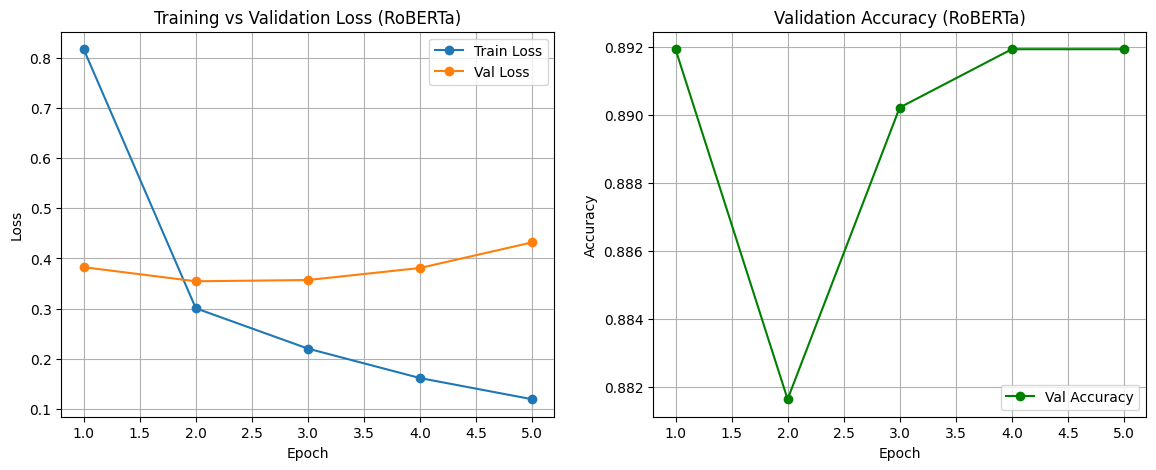

In [38]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], marker='o', label="Train Loss")
plt.plot(epochs, history["val_loss"], marker='o', label="Val Loss")
plt.title("Training vs Validation Loss (RoBERTa)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["val_acc"], marker='o', label="Val Accuracy", color="green")
plt.title("Validation Accuracy (RoBERTa)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()

plt.show()
